# Processing TES Peak Data into Photon Counts

The EFADC saves all measured data as .bin files, and the python script EFADC_decode3.py converts the binary data into human readable .csv files with all of the necessary peak data at each time step. At this point, the user has the freedom about the usage of the data. For the the current work, focus remains on the peak height and peak area to determine photon number counts at each time step. Occassionally, peak time is important to ensure that signal timing align, and to eliminate noise photons that may impinge on the detector at the incorrect time.

When determining what peak paramters to use when determining binning for photon counts, there is some freedom about how the data can be used. Several approaches were attempted for this work, but the analysis focused on those methods that optimized the separation between groupings in a given histogram so as to minimize overlap between potential photon-number binning and thus given better distinction to events. The methods that yield the best results were relative peak height and relative area. The relative peak height is defined as the absoulte recorded peak height minus the pedestal value (the value of the signal voltage exactly at the trigger). This works quite well at differentiating events, but only at low photon numbers (0-4). Depending on TES bias and photon flux, the absolute peak height or relatvie peak height may work better. Relative area is defined as the measured area minus the area of the rectangled defined by the duration of the peak multiplied by TETHi. This value gave the least noise out of all methods considered and allowed for decent peak differentiation all the way out to 30 photons. The relative peak height can be used to verify the efficacy of the area method at low photon number. 

In [1]:
import numpy as np
from qutip import* #need to download
import struct
import os, glob
import scipy.io
import bitarray as b #need to download
import matplotlib.pyplot as plt
import csv
from scipy.special import factorial as fac
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from numpy import array
def flatten(t):
    #use to flatten lists
    return [item for sublist in t for item in sublist]

First, the .csv files must be loaded in. In this example, there is one data file for every 250,000 triggers at each channel where data was recorded. Thus, 'data4' has 2 channels (Ch1-Ch2) and 2,500,000 triggers (10 subfiles). The data is stored in outdat and indexed as outdat[i][j][k], where i is the file number, j is the channel number, and k is the type of data indexed by header, which is printed out below. As an example, outdat[0][1][4] gives an array of all the peak times in order for channel 2 for the first data files, data4_0Ch1.csv and data4_0Ch2.csv.

In [2]:
filenames=[]
numfiles=2
basename='/data4_'
for i in range(numfiles):
    filenames.append(os.getcwd()+basename+str(i))
    
outdat=[]
for k in range(numfiles):
    chdata=[]
    for i in range(8):
        fpath=str(filenames[k])+'Ch'+str(i+1)+'.csv'
        if os.path.exists(fpath):
            file=open(fpath)
            datafile=csv.reader(file)
            header=next(datafile)
            rows=[]
            for row in datafile:
                rows.append(row)
            chdata.append(np.asarray(rows,dtype=float).T)
            file.close()

    outdat.append(chdata)


print('Data ordering: ', header) 


Data ordering:  ['Trigger time', 'Channel number', 'Area', 'Peak Height', 'Peak Time', 'End Time', 'Start Time', 'Pedestal', 'overflow', 'underflow']


The below section takes the outdat variable above and reorganizes it into separate variables for each channel. The values of TEThi for each channel should be included, as these are used to aid in the cacluation of relative peak area.

Additionally if one is using shutters and on/off locking, there is the option to remove pulses on each channel surrounding the shutter. This is necessary because there are several miliseconds of delay when the shutters open and/or close where signal may be different between the TES channels due to variations in the mechanical shutters and slight timing mismatches. Discarding data from about 225 of the pulses before the shutter closes and after it opens ensures the rest of the data is consistent. Also, the data at the edges has different TES behavior as it transitions to no photon flux to very high photon flux, meaning the peak information for the first few events after the shutter opens is unreliable.

The code to do this looks for how long it has been since an event occurred, and if it is too long (greater than max_timesep number of triggers), then the code assumes a shutter had been closed, and it removes the trim_fr events from each channel before the shutter and trim_bk events after the shutter. Additionally, one should inclue the approximate separation in terms of trigger clock as pulse_sep. Note that the EFADC samples one data point every 4 ns.

***Note:*** Even if the shutters are on, this removing of peaks should ***only** be used when calibrating a coherent state or calculating the histograms used for binning. When heralding, the timestamps of the single photons allow for determining which events to keep.

In [3]:
TEThi0=500; TEThi1=350; TEThi2=250; #TET settings in the runinit file for each channel

#coherent state calibration variables
ch0area=[]; ch0pheight=[]; ch0Rarea=[]; ch0Rpheight=[]; ch0trigtime=[]; ch0ptime=[];
ch1area=[]; ch1pheight=[]; ch1Rarea=[]; ch1Rpheight=[]; ch1trigtime=[]; ch1ptime=[];
ch2area=[]; ch2pheight=[]; ch2Rarea=[]; ch2Rpheight=[]; ch2trigtime=[]; ch2ptime=[];

#pulse_sep=20050 #clock timestamp difference between pulses. Here, 20050 corresponds to 20050 x 4ns = 80.2 microseconds
#max_timesep=400 #max number of triggers allowed between events before assuming it was from a shutter being closed
#trim_fr=225 # amount of triggers to remove before shutter opens
#trim_bk=225 # amount of triggers to remove after shutter closes

for i in range(numfiles):
        for k in range(2):
            trigtime=outdat[i][k][0]
            sort_times=np.argsort(trigtime) #sorts timestamps correctly
            good_idx=np.arange(0,len(sort_times),1)
            
            '''#This section finds breaks in the data from shutters closing and
            #calculates a "good index" array that is for the timestamps I want
            #to keep. I can then use this for all data
            
            scal_dif=np.diff(trigtime[sort_times])/pulse_sep
            breaks=np.where(scal_dif>max_timesep)[0]
            size=len(scal_dif)+1
            if len(breaks>0):
                if breaks[0]==0:
                    good_idx=np.arange(breaks[0]+trim_fr,breaks[1]-trim_bk,1)
                    offset=1
                else:
                    good_idx=np.arange(0,breaks[0]-trim_bk,1)
                    offset=0
                for m in range(len(breaks)-offset-1):
                    good_idx=np.append(good_idx,np.arange(breaks[m+offset]+trim_fr,breaks[m+1+offset]-trim_bk,1))
                good_idx=np.append(good_idx,np.arange(breaks[-1],size,1))'''
            
            height=((outdat[i][k][3])[sort_times])[good_idx]
            area=((outdat[i][k][2])[sort_times])[good_idx]
            eval('ch'+str(k)+'area').append(area) #channel areas
            #eval('ch'+str(k)+'Rarea').append(area-(((outdat[i][k][5]-outdat[i][k][6])
            #                                        *eval('TETlow'+str(k)))[sort_times])[good_idx])

            eval('ch'+str(k)+'Rarea').append(area-(((outdat[i][k][5]-outdat[i][k][6])
                                                    *eval('TEThi'+str(k)))[sort_times])[good_idx])
            #Alternative method for determining relative areas using the pedestal values. This does not seem to work as well.
            #eval('ch'+str(k)+'Rarea').append(area-(((outdat[i][k][5]-outdat[i][k][6])
            #                                        *outdat[i][k][7])[sort_times])[good_idx])


            eval('ch'+str(k)+'pheight').append(height) #channel peak heights
            eval('ch'+str(k)+'Rpheight').append(height-((outdat[i][k][7])[sort_times])[good_idx]) #channel relative peak heights
            eval('ch'+str(k)+'ptime').append(((outdat[i][k][4])[sort_times])[good_idx]) #channel peak times
            eval('ch'+str(k)+'trigtime').append((trigtime[sort_times])[good_idx]) #channel trigger times
            
all_areas=[np.array(flatten(ch0area)),np.array(flatten(ch1area)),np.array(flatten(ch2area))] #raw areas
all_Rareas=[np.array(flatten(ch0Rarea)),np.array(flatten(ch1Rarea)),np.array(flatten(ch2Rarea))] #Relative area, right now subtracts a rectangle from start time to end time at TETHi
all_pheight=[np.array(flatten(ch0pheight)),np.array(flatten(ch1pheight)),np.array(flatten(ch2pheight))] #raw peak height
all_Rpheight=[np.array(flatten(ch0Rpheight)),np.array(flatten(ch1Rpheight)),np.array(flatten(ch2Rpheight))] #Rpheight = relative peak height, takes peak height and subtracts the pedestal
#all_RhRa=[np.array(flatten(ch0RhRa)),np.array(flatten(ch1RhRa)),np.array(flatten(ch2RhRa))]      
all_ptime=[np.array(flatten(ch0ptime)),np.array(flatten(ch1ptime)),np.array(flatten(ch2ptime))]  #peak times     
all_trigtime=[np.array(flatten(ch0trigtime)),np.array(flatten(ch1trigtime)),np.array(flatten(ch2trigtime))] #all trigger times

print('The number of recorded area events on Ch1 is given by:', len(all_areas[0]))

The number of recorded area events on Ch1 is given by: 500000


The above variables are indexed based on channel number, e.g., all_areas[0] gives the areas for all files for Channel 1.

For the rest of the file, let's focus on the data from Channel 2. First, let's plot a histogram of the peak heights.

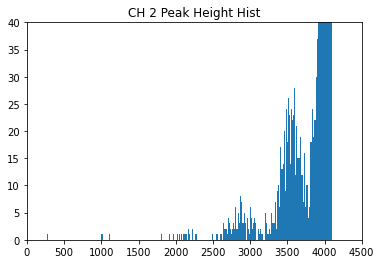

The proportion of two photon peaks is about  3.4e-05


In [65]:
histvals=np.hstack(all_pheight[1])
plt.hist(histvals,bins=1000);
plt.xlim([0,4500])
plt.ylim([0, 40])
plt.title('CH 2 Peak Height Hist')
plt.show()

twophot_idx=(all_pheight[1]<2400)*(all_pheight[1]>1600)
print('The proportion of two photon peaks is about ', len(all_pheight[1][twophot_idx])/len(all_pheight[1]))

In this example, the photon flux is very high (mean photon number ~14), so there is a low chance of having low photon numbers. With the bias settings here, the peak height saturates quickly around the 5 photon mark, thus only 0-4 can be resolved with the height method. However, one can clearly see the distinction between the 0 photon events (less that 500 height), the 1 photon events (heights 500-1500), the 2 photon events (heights 1500-2400), and 3 photon events (heights 2450-3200). These values can be used as a self-consistency method to check binning obtained from another method, such as areas.

Below, I show the relative area histogram for the data. The first is log scale and the second is regularly scaled, which is spread out over 4 separate graphs with continuation in area to account for scales. We can now compare the number of two photon peaks from this method and see if it agrees with the previous peak height methodology.

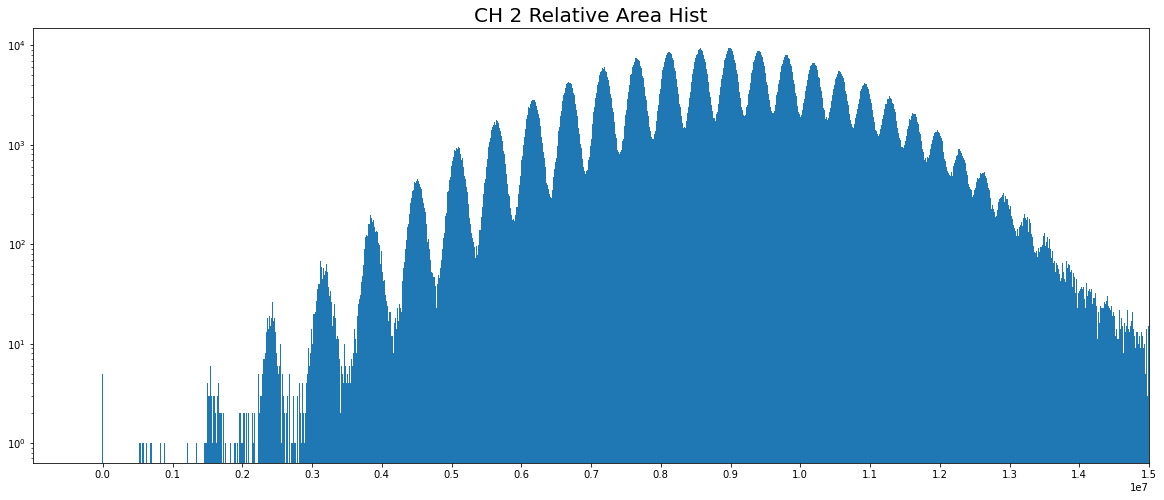

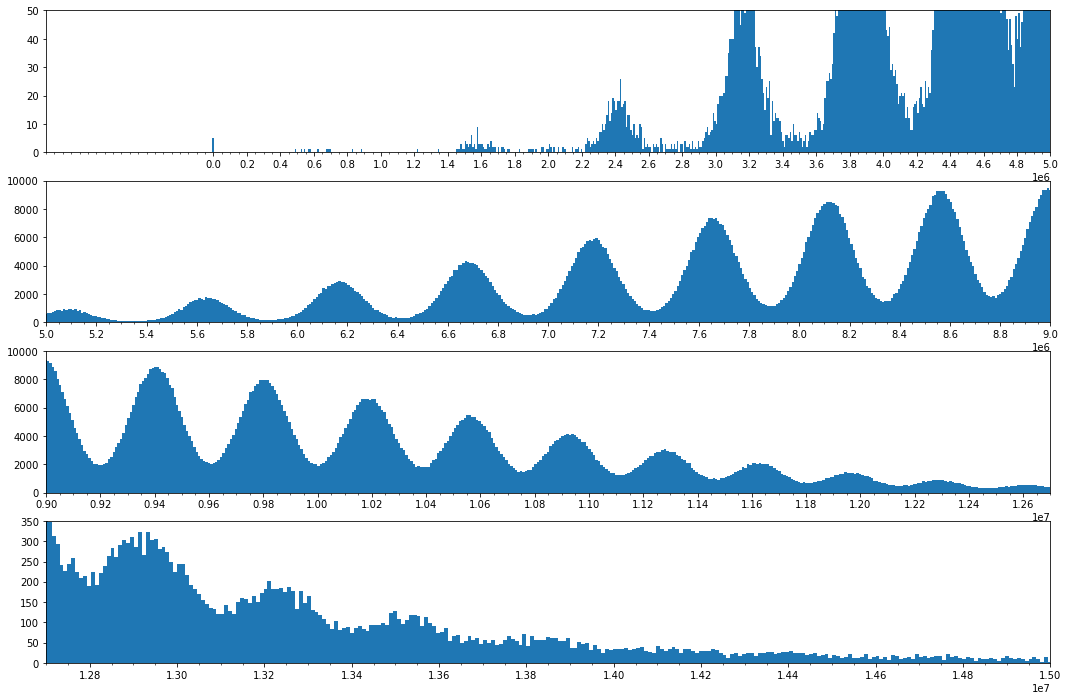

The proportion of two photon peaks is about  3.64e-05


In [482]:
histvals=np.hstack(all_Rareas[1])
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yscale('log')
ax.hist(histvals,bins=2500);
ax.set_xticks(np.linspace(0,2e7,21))
ax.set_xlim([-1e6,15e6])


plt.title('CH 2 Relative Area Hist',fontsize=20)
plt.show()

xlims=[-1e6,5e6,9e6,12.7e6,15e6]
ylims=[50,10000,10000,350]
fig, ax = plt.subplots(4, sharey='row',figsize=(18, 12))
for k in range(4):
    ax[k].hist(histvals,bins=2500);
    ax[k].set_xticks(np.linspace(0,2e7,101))
    ax[k].xaxis.set_minor_locator(MultipleLocator(5e4))
    ax[k].set_xlim([xlims[k],xlims[k+1]])
    ax[k].set_ylim([0,ylims[k]])

plt.show()


twophot_idx=(all_Rareas[1]<2e6)*(all_Rareas[1]>1.2e6)
print('The proportion of two photon peaks is about ', len(all_Rareas[1][twophot_idx])/len(all_Rareas[1]))

From the two different methods, the two photon contributions agree quite well, so this indicates our method is working.

One can now determine threshold markers from the minimum between each of the histogram peaks. These values can be put in 'by hand' for quick results, or one can fit each peak to a Gaussian distribution and find the interesection with neighboring peaks to determine the binning. This is demonstrated at the end of this code, but surprisingly, the 'by hand' results are quite robust and nearly as accurate as the results obtained by numerically performing the fits. The results of the binning can also be verified by checking the sum-squared error of the measured distribution with that of an expected coherent state. For now, let's just put in the values by hand. 

***Note:*** These binning thresholds must be verified and changed for each and every data set. This is because these values are dependent upon the specific TES detector used, TES bias settings, TES temperature, EFADC settings, and input coherent state power. As a side point, the dependence on the coherent state power has more to do with the time between pulses and the electronic amplification and High-pass filtering after the TES measures the events.

In [4]:

ch2Rathresh=[0.4e6,1.2e6,2e6,2.8e6,3.5e6,4.15e6,4.8e6,5.35e6,5.9e6,6.4e6,6.925e6,7.4e6,7.9e6,8.35e6,8.775e6,9.2e6,9.6e6,1.00e7,1.0375e7,1.075e7,1.1115e7,1.145e7,1.18e7,1.215e7,1.2475e7,1.28e7,1.31e7,1.34e7,1.37e7,1.4e7,1.425e7,1.46e7]

'''The below threshold are from Gaussian fits, the above are 'by eye'. Both methods are surprisingly similar'''
#ch2Rathresh=[0.4e6, 1109850.,  1976700.,  2750850.,  3497850.,  4163400.,  4775100.,
#        5339250.,  5884950.,  6408000.,  6915300.,  7402800.,  7874250.,
#        8328450.,  8765550.,  9187050.,  9591750.,  9994650., 10371750.,
#        10744050., 11103900., 11455050., 11796300., 12137400., 12453150.,
#        12781200., 13087050., 13410300., 13695300., 13997850., 14289150.,1.455e7]

"The below threshold are from Gaussian fits, the above are 'by eye'. Both methods are surprisingly similar"

The next section accounts for the events that ***aren't*** recorded by the EFADC at all. This occurs when the signal never crosses TEThi, which means we should count it as a 0 photon event. However, it is still important to keep track of these events, as simply discarding them will alter the statistics. In this case, TEThi was set slightly into the noise floor, thus there were no events that weren't caught, and all zero photon events were seen directly. However, the next section will be necessary if this isn't the case. 

In [5]:
pulse_sep=22500
zeroidx_insertch1=[]
zeroidx_insertch2=[]
new_areas=[]
new_trigtime=[]
for k in range(2): #loops through both channels. Change loop range for more channels
    skips=np.where(np.diff(all_trigtime[k+1])>pulse_sep+1000) #skips should be greater than pulse_sep but less than 2 X pulse_sep
    c=0
    for i in range(len(skips[0])-1):
        #The below if statement is necessary to remove events that are separated by exactly 1000. I am unsure why this happens, but it seems like there is some systematic fictitious skipping that occurs, either due to pulse-generator reset or extra data timestamps by the DAC. Either way, these events are not real.
        if (skips[0][i+1]-skips[0][i])!=1000:
            c+=1
            print(skips[0][i])
            if np.mod(c,2)==1 and c!=1:
                eval('zeroidx_insertch'+str(k+1)).append(skips[0][i]+1)
    #print(eval('zeroidx_insertch'+str(k+1)))
    new_areas.append(np.insert(all_Rareas[k],eval('zeroidx_insertch'+str(k+1)),
                               np.zeros(len(eval('zeroidx_insertch'+str(k+1))))))
    new_trigtime.append(np.insert(all_trigtime[k],eval('zeroidx_insertch'+str(k+1)),
                                  (all_trigtime[k][eval('zeroidx_insertch'+str(k+1))]-22500)))

print('size of new areas, including zero events. This should the same as the number of actual triggers sent', len(new_areas[1]))

size of new areas, including zero events. This should the same as the number of actual triggers sent 500000


The code segment below now uses the thresholds for binning defined above, along with the new areas arrays and determines the probability of a photon to be in each bin. For this example, I make the peak thresholds for Ch1 the same as for Ch2 (so the code could still be left general for multiple channels). Note that this will not give the correct results for channel 1, as the binning must be done independently for each channel. Additionally, I removed all events with areas larger than the highest threshold, as these have indeterminate photon number, although certainly equal to or larger than the highest photon number resolvable. Depending on the instance, it may be useful to keep track of these separately. For the current illustration, I just ignore them, which can safely be done as they account for less that above 0.3% of events.

While calculating the probabilities, the below code also calculates a bit string based on the parity of the measured event (0 for even and 1 for odd), in addition to a string containing the results of the measured photon number modulo 4. These can both be used for unbiased random number generation as discussed further in the main document.

In [7]:
ch1Rathresh=np.array(ch2Rathresh)
numtrigs=len(new_areas[1])

coher_probs1=[];
coher_probs2=[];
phot_num_ch1=np.zeros(len(new_areas[0]));
phot_num_ch2=np.zeros(len(new_areas[1]));

for k in range(2):
    #pthresh=eval('ch'+str(k)+'pthresh') #peak thresholding can be used instead of area
    athresh=eval('ch'+str(k+1)+'Rathresh') #used for the area thresholds for each channel
    start_A=new_areas[k]
    bad_idx=start_A>athresh[-1] #gets rid of all events that can't be resolved: those with areas larger than the highest threshold
    tmpA=start_A[~bad_idx]
    numevents=len(tmpA)
    vars()['bitstring'+str(k+1)]=np.zeros(numevents);
    vars()['mod4_bitstring'+str(k+1)]=np.zeros(numevents);
    #numevents=len(tmpA)
    for i in range(len(athresh)+1):
        if i==0:
            idx=tmpA<athresh[i]
            #prob=(len(tmpA[idx])+numtrigs_approx-len(tmpA))/numevents
            prob=len(tmpA[idx])/numevents
            eval('bitstring'+str(k+1))[idx]='00'
            eval('phot_num_ch'+str(k+1))[idx]=i
        elif i==len(athresh):
            #can assign all events greater than max threshold value to one bin, or ignore them 
            #idx=tmpA>athresh[i-1]
            #prob=len(tmpA[idx])/numevents
            prob=0
            eval('phot_num_ch'+str(k+1))[idx]=float("NaN")

        else:
            lowlim=athresh[i-1]
            uplim=athresh[i]
            idx=(lowlim<tmpA)*(tmpA<uplim)
            prob=len(tmpA[idx])/numevents
            eval('phot_num_ch'+str(k+1))[idx]=0
            eval('phot_num_ch'+str(k+1))[idx]=i

            if np.mod(i,2)==1:
                eval('bitstring'+str(k+1))[idx]=1
                
            if np.mod(i,4)==0:
                eval('mod4_bitstring'+str(k+1))[idx]=0
            elif np.mod(i,4)==1:
                eval('mod4_bitstring'+str(k+1))[idx]=1
            elif np.mod(i,4)==2:
                eval('mod4_bitstring'+str(k+1))[idx]=2
            else:
                eval('mod4_bitstring'+str(k+1))[idx]=3
            
        eval('coher_probs'+str(k+1)).append(prob) 
            
print('The numbe of events within the calibrated thresholds for Channel 2 is: ', numevents)
    
print('probability of odd on Ch2: ', np.dot(np.mod(range(len(coher_probs2)),2),coher_probs2))

'''CH2 probs of 0-3'''
print('probability of mod4=0: ', len(mod4_bitstring2[mod4_bitstring2==0])/len(mod4_bitstring2))
print('probability of mod4=1: ', len(mod4_bitstring2[mod4_bitstring2==1])/len(mod4_bitstring2))
print('probability of mod4=2: ', len(mod4_bitstring2[mod4_bitstring2==2])/len(mod4_bitstring2))
print('probability of mod4=3: ', len(mod4_bitstring2[mod4_bitstring2==3])/len(mod4_bitstring2))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 500000 but corresponding boolean dimension is 498489

The below code can be used to save data. It if the .open() command on a file is used, it is ***always*** necessary to have the corresponding .close()

In [142]:
#bitstringdata=bitstring1.astype(int)
#file=open(os.getcwd()+basename+"bitarray_testdata"+".bin","wb")
#num=bytearray(list(bitstringdata))
#file.write(num)
#file.close()


Now, let's examine how well the binned data corresponds to a coherent state. After plotting the measured distribution, we can check the sum-squared error (SSE) with the expected distribution. Becase we are sending a coherent state, $$|\alpha\rangle=e^{-|\alpha|^2/2}\sum^\infty_{n=0}\frac{\alpha^n}{\sqrt{n!}},$$
we see that the expected photon number distribution should follow the Poissonian distribution of $$P(n)=e^{-|\alpha|^2}\frac{|\alpha|^{2n}}{n!}$$ where $|\alpha|^2$ is the mean photon number. However, if there is some error, we can assume that perhaps the measured mean photon number is not precisely the same as the photon number of the best fit coherent state (due to amplitude noise or binning error). Instead, we can simply plot the SSE as a function of $\alpha$ and find the minium value.

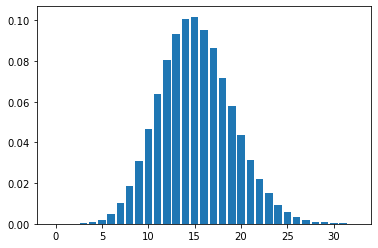

The measured mean photon number is given by:  15.14062923710116
The photon number probabilities for this coherent state are:  [2.005728360196722e-06, 4.412602392432788e-06, 3.610311048354099e-05, 0.00018252128077790168, 0.0006622915045369575, 0.0019194820407082628, 0.004695410091220526, 0.00998010317466685, 0.018671325305071283, 0.030967242444421266, 0.04676516130067473, 0.06395425334756064, 0.08044896223614643, 0.09347536564428006, 0.10081512800558395, 0.10178429594923101, 0.0954995467053906, 0.0862756031225179, 0.07154232487985687, 0.05773769886796691, 0.04362338839726258, 0.031581797613985545, 0.021903355984692282, 0.01491058462970243, 0.009027382203573405, 0.0057756953860224804, 0.003313864396717024, 0.0020101409625891548, 0.0011155861139414166, 0.0006783373314185313, 0.0003907158845663214, 0.0002479080253203148, 0]


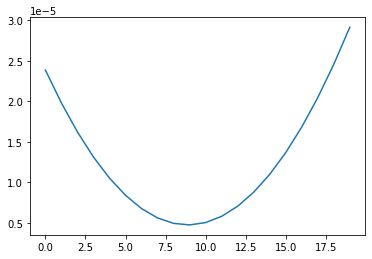

4.761659602312153e-06


In [491]:
plt.bar(range(len(coher_probs2)),coher_probs2)
plt.show()
meas_meanch2=np.dot(range(len(coher_probs2)),coher_probs2)
print('The measured mean photon number is given by: ', meas_meanch2)
print('The photon number probabilities for this coherent state are: ', coher_probs2)
#Try fitting to a coherent state
meas_dist=np.asarray(coher_probs2)
sse=[]
N_dim=40
for k in range(20): #set to determine number of loop iterations
    #mu=np.sqrt(24.7+0.01*k)
    mu=np.sqrt(meas_meanch2-0.1+0.01*k) #coherent state amplitude
    test=coherent_dm(N_dim,mu) #theory coherent state
    sse.append(np.sum(np.abs((meas_dist[0:30]/(np.sum(meas_dist[0:30])))
                             -(test.diag()[0:30])/(np.sum(test.diag()[0:30])))**2))
plt.plot(sse)
plt.show()
print(np.min(sse)) #try to minimize sse

The second plot from the above codes plots the SSE vs the index of the loop, which has a minimum value on about the 8th iteration. This corresponds to an alpha value of 15.11, which is very near the calculated mean photon number. Furthermore, the SSE is quite low, indicating that the binning was performed properly. Without checking the SSE fit with a true coherent state, it may be difficult to ascertain that the binning is in fact correct due to low sampling at some photon numbers. For example, in the histogram of areas shown several cells above, there are very few events with near zero area (below 0.2e6). One might be tempted to erroneously group all events with relative areas less than 1.0e6 as a single bin to call all of them zero photons. However, one can easily check that this would be incorrect, as re-running the above few cells by doing this (after removing the first value in ch2Rathresholds) would give a distribution that qualitatively looks like a coherent state, but the SSE will in fact be about an order of magnitude worse. Thus, the true distribtuion binning follows the thresholds used above.

Once the bin fitting is assured, the same process with SSE can be performed with amplitude noise or thermal noise to determine the quality of the measured coherent state. While the above test was more to determine if the data processing was performed correctly, the below is more to diagnose the measured state.

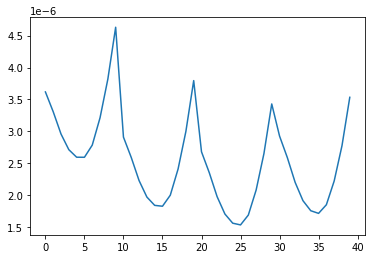

1.5291066076581972e-06
Optimal parameters occur when the state is a mixture of coherent states with a central mean photon number of  [15.13062924]  and is mixed with other coherent states having a Gaussian standard deviation of sigma= [0.065]


In [195]:
#Try a mixture of gaussian distributed coherent states

meas_dist=np.asarray(coher_probs2)
sse=[]
for k in range(4):
    #mu=np.sqrt(24.7+0.01*k)
    mu=np.sqrt(meas_meanch2-0.03+0.01*k)
    for j in range(10):
        sigma=0.04+0.005*j
        test=0
        dx=0.01
        steps=6*round(sigma/(dx))
        xvec=np.linspace(mu-steps*dx/2,mu+steps*dx/2,steps)
        for x in xvec:
            test=test+np.e**(-(mu-x)**2/(2*sigma**2))*coherent_dm(N_dim,x)
        test=test/test.tr()
        sse.append(np.sum(np.abs((meas_dist[0:30]/(np.sum(meas_dist[0:30])))
                          -(test.diag()[0:30])/(np.sum(test.diag()[0:30])))**2))
plt.plot(sse)
plt.show()
print(np.min(sse))
minloc=np.where(sse==np.min(sse))[0]
print('Optimal parameters occur when the state is a mixture of coherent states with a central mean photon number of ', meas_meanch2-0.03+0.01*np.floor(minloc/10), ' and is mixed with other coherent states having a Gaussian standard deviation of sigma=', 0.04+0.005*np.mod(minloc,10))

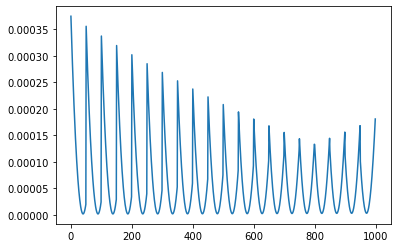

1.4896181285011333e-06
Optimal parameters occur when the coherent state has mean photon number  [14.64062924]  and is convolved with thermal noise with mean photon number,  [0.5]


In [196]:
#Try a mixture of a coherent state convolved with a thermal state
meas_dist=np.asarray(coher_probs2)
sse=[]
for k in range(20):
    #mu=np.sqrt(24.7+0.01*k)
    mu=np.sqrt(meas_meanch2-0.5+0.01*k)
    coher=coherent_dm(N_dim,mu).diag()
    for j in range(50):
        thrmamp=0.1+0.01*j
        dist=np.convolve(coher,thermal_dm(N_dim,thrmamp).diag())
        sse.append(np.sum(np.abs((meas_dist[0:30]/(np.sum(meas_dist[0:30])))
                          -(dist[0:30])/(np.sum(dist[0:30])))**2))
plt.plot(sse)
#plt.ylim([0.01,0.02])
plt.show()
print(np.min(sse))
minloc=np.where(sse==np.min(sse))[0]
print('Optimal parameters occur when the coherent state has mean photon number ', meas_meanch2-0.5+0.01*np.floor(minloc/50), ' and is convolved with thermal noise with mean photon number, ', 0.1+0.01*np.mod(minloc,50))

Both of the above fits (extra thermal noise vs amplitude noise) have roughly the same SSE so would both be good model fits. However, considering that the fits are about the same, we can consider the fact the the TES has almost negligible dark count, and without any external light, the chances of having thermal noise this large is quite small. Thus, we can conclude that the likely explanation is in fact amplitude noise, either on the laser or due to fiber effects. This is shown in the direct comparison plot below.

Mean photon number of ideal coherent state:  15.11
Spread in mean photon number:  14.878223795595902  to  15.3838887044041


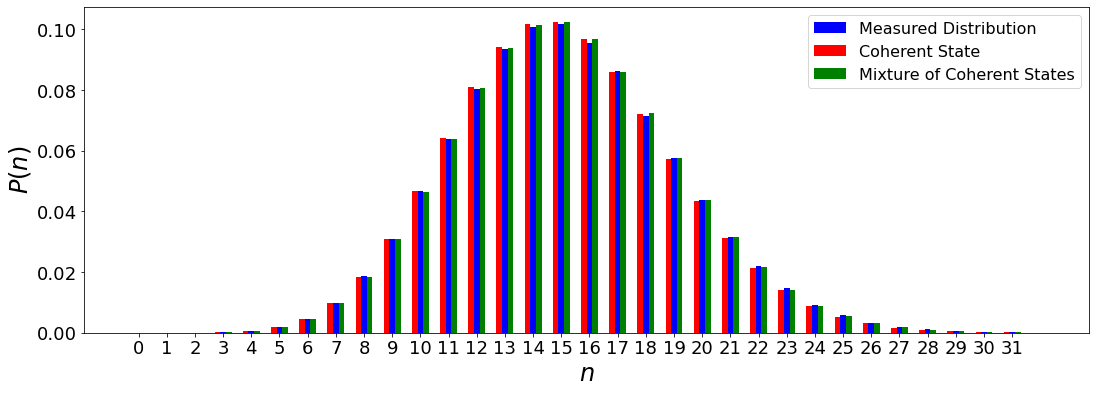

In [202]:
N_dim=40
coher_appx=coherent_dm(N_dim,np.sqrt(15.11))
#sqcoher_appx=ket2dm(squeeze(N_dim,-0.0692)*coherent(N_dim,np.sqrt(5.579)))

mu=np.sqrt(15.13)
sigma=0.065
mix=0
dx=0.01
steps=6*round(sigma/(dx))
xvec=np.linspace(mu-steps*dx/2,mu+steps*dx/2,steps)
xvec=np.linspace(mu-sigma/2,mu+sigma/2,2*round(sigma/(dx)))
for x in xvec:
    mix=mix+np.e**(-(mu-x)**2/(2*sigma**2))*coherent_dm(N_dim,x)
            
#plt.subplots(figsize=(10, 5))
plt.figure(figsize=(18,6))
ax = plt.subplot(111)
x=range(N_dim)
#ax.bar(np.array(range(N_dim))-0.2, (test/test.tr()).diag(), width=0.2, color='b', align='center')
ax.bar(np.array(range(len(coher_probs2))),coher_probs2, width=0.2, color='b', align='center',label='Measured Distribution')
ax.bar(np.array(range(N_dim)[0:32])-0.2, coher_appx.diag()[0:32], width=0.2, color='r', align='center',label='Coherent State')
ax.bar(np.array(range(N_dim)[0:32])+0.2,(mix/mix.tr()).diag()[0:32], width=0.2, color='g', align='center', label='Mixture of Coherent States')
#ax.bar(np.array(range(N_dim)[0:30])+0.2,dist[0:30], width=0.2, color='g', align='center', label='Mix with Thermal')
ax.legend(fontsize=16)
ax.set_xticks(np.array(range(32)))
ax.tick_params(axis='both',labelsize=18)
ax.set_xlabel('$n$',fontsize=24)
ax.set_ylabel('$P(n)$',fontsize=24)
#ax.bar(np.array(range(len(coher_probs2)))+0.3,coher_probs2, width=0.4, color='r', align='center')
#print('Squeezing in db: ',20*np.log10(np.e**-0.0692))
#print('Fidelity with coherent state: ', fidelity(coher_appx,meas_coher)**2)
#print('Fidelity with squeezed coherent state: ', fidelity(sqcoher_appx,meas_coher)**2)
print('Mean photon number of ideal coherent state: ', 15.11)

print('Spread in mean photon number: ',(mu-sigma/2)**2, ' to ',(mu+sigma/2)**2)

plt.show()

# Gaussian Binning

The next set of code will show how to systematically determine the photon binning by taking the area histograms and fitting a Gaussian function to each peak, and setting the bin threshold at the intersection point between the two Gaussians. This method is the most accurate way to bin the histograms, although it surprisingly differs little from binning manually.

First, define two functions that will compute and return an array that is a Gaussian sum. Both of these functions take in an array of Gaussian parameters grouped in 3-tuples and an array-like x vector. The Gaussian parameters are input such that in each triple, the first parameter is the center of the Gaussian, the second parameter is the amplitude, and the third parameter is the standard deviation. 

In [203]:
def gauss_sum(params,x):
    f = np.zeros_like(x)
    for k in range(round(len(params)/3)):
        ctr = params[3*k]
        amp = params[3*k+1]
        wid = params[3*k+2]
        f = f + amp * np.exp( -((x - ctr)/wid)**2/2)
    return f

def gauss_sum_normed(params,x):
    f = np.zeros_like(x)
    for k in range(round(len(params)/3)):
        ctr = params[3*k]
        amp = params[3*k+1]
        wid = params[3*k+2]
        f = f + np.exp( -((x - ctr)/wid)**2/2)/np.sqrt(2*np.pi*wid**2)
    return f

Take the the histogram used earlier, but now turn it into a function with defined bin heights and bin centers. Note that the number of bins determines the size of the xvector as used later.

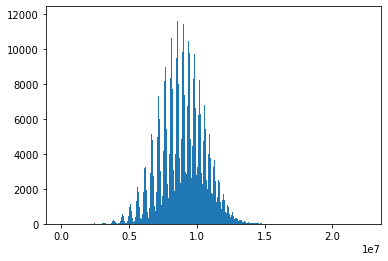

In [213]:
histvals=np.hstack(all_Rareas[1])
bin_heights, bin_borders, _ = plt.hist(histvals, bins=2000, label='histogram')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2


Now, define a method that will fit an input function to a sum of Gaussian functions. This is achieved by the below function, which takes several parameters. The first two inputs are the two arrays that define the function to be fit (the bin_centers and bin_heights). The next parameters, pkprom, determines the minimum peak prominence the peakfinder should use when assigning Gaussian peaks to the data. The start and stop are xvector values that are used to determine which subset of the data is being fit, while num_Gauss tells the function how many Gaussians should be used to fit the data. Widthguess is the starting peak standard deviation in terms of xvector indices use for the guess for the optimizer. Finally, maxiters limits how many cycles the optimizer can run through.

Because the histogram contains peaks on vastly different scales, it is impossible with the current method to catch each and every peak all at once. Thus some cross between a manual and automated fitting process is need to catch all possible peaks. The histogram can be sectioned into groupings of peaks with same order-of-magnitude amplitude, and each of these peaks can be fit with the optimizer. After all sections of the histogram have been fit, they can all be stitched together at the end.

In [373]:
'''attempt at curve fitting codes'''
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def func(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i] #center of Gaussian
        amp = params[i+1] #amplitude of Gaussian
        wid = params[i+2] #width of Gaussian
        #constshift=params[i+3] #constant offset to data
        y = y + amp * np.exp( -((x - ctr)/wid)**2/2)#+constshift
    return y
def gauss_curve_fit(bin_centers,bin_heights,pkprom,start,stop,num_Gauss,widthguess,maxiters):
    
    x=bin_centers[start:stop]
    y=bin_heights[start:stop]
    peaks=find_peaks(y, distance=15,prominence=pkprom) #finds the peaks and peak locations with scipy function

    #plt.plot(x,y)
    #plt.show()
    peaklocs=(peaks[0]+start)*bin_centers[-1]/len(bin_heights) #peak locations
    #wid_guess=10*bin_centers[-1]/100
    wid_guess=widthguess
    #guess = [peaklocs[0],2,0.1e6,peaklocs[1],4,0.1e6,peaklocs[2],9,1e6]
    guess=[]
    #the number of how many Gaussian to use in the fit
    for i in range(num_Gauss): 
        #guess += [peaklocs[i+3], bin_heights[peaks[0][i+3]], 20*bin_centers[-1]/1000]   
        guess += [peaklocs[i], bin_heights[peaks[0][i]+start],wid_guess ] #guess vals for Gaussain, center of G, height of G, and Std. dev. of G

    popt, pcov = curve_fit(func, x, y, p0=guess,bounds=(0,np.inf),maxfev = maxiters)
    #print(popt)
    fit = func(x, *popt)

    plt.plot(x,y)
    plt.plot(x, fit , 'r-')
    plt.show()
    
    return fit,popt


In this example, I start by fitting the 1-4 photon peaks first. Note that the zero peak is too sharp for a Gaussian fit to work for several reasons. First, the zero photon peak occurs for recorded events as well as non-recorded events, meaning that there may be less data which compounds with the fact that zero photon events are already quite rare in this data set. Additionally, the peak would be skewed right, as the left half is cut off at zero. Thus, while the other peaks can be fit with the optimizer, the zeroth-order cuttoff is determined by half the distance from zero to the first peak.

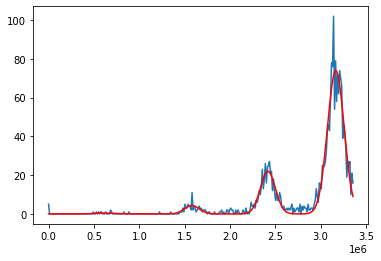

Gaussian fit parameters are given by  [6.04001084e+05 4.60611019e-01 9.94996845e+04 1.57928168e+06
 4.31243203e+00 8.23284133e+04 2.41674599e+06 2.19823036e+01
 8.25616420e+04 3.16664210e+06 7.40006767e+01 9.18434976e+04]


In [374]:
fit1=gauss_curve_fit(bin_centers,bin_heights,2,0,300,4,2e5,100000)
print('Gaussian fit parameters are given by ', fit1[1])

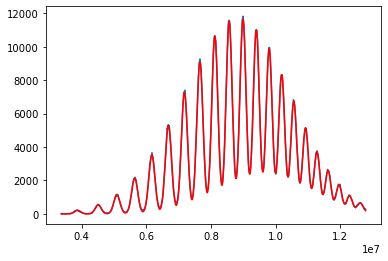

Gaussian fit parameters are given by  [3.86327020e+06 2.11696709e+02 9.81853096e+04 4.50898195e+06
 5.42158825e+02 9.47704394e+04 5.08723614e+06 1.13339910e+03
 9.74796763e+04 5.63882344e+06 2.14023786e+03 9.66295090e+04
 6.16943035e+06 3.52592695e+03 9.76375196e+04 6.68308308e+06
 5.29137764e+03 9.84758549e+04 7.17881799e+06 7.27936897e+03
 9.79727601e+04 7.65702086e+06 9.09967249e+03 9.87779600e+04
 8.11823309e+06 1.06392778e+04 9.81042276e+04 8.56181451e+06
 1.15191332e+04 9.78291815e+04 8.98965294e+06 1.16530548e+04
 9.76223221e+04 9.40312187e+06 1.10216200e+04 9.70047816e+04
 9.80161978e+06 9.88222373e+03 9.64529366e+04 1.01886964e+07
 8.33741350e+03 9.64219152e+04 1.05633727e+07 6.73575535e+03
 9.52499188e+04 1.09271043e+07 5.13865811e+03 9.44273492e+04
 1.12803901e+07 3.71501507e+03 9.48725115e+04 1.16246545e+07
 2.59933168e+03 9.32132540e+04 1.19613181e+07 1.74611643e+03
 9.49308624e+04 1.22867768e+07 1.08828345e+03 9.05731504e+04
 1.26163966e+07 6.47513413e+02 1.10101529e+05]


In [430]:
fit2=gauss_curve_fit(bin_centers,bin_heights,200,300,1140,21,0.3e5,100000)
print('Gaussian fit parameters are given by ', fit2[1])

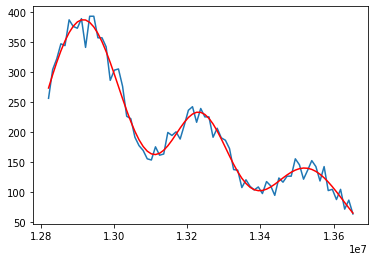

Gaussian fit parameters are given by  [1.29162212e+07 3.87191385e+02 1.13141100e+05 1.32348811e+07
 2.22284577e+02 8.35333280e+04 1.35226247e+07 1.39018462e+02
 1.04863667e+05]


In [470]:
fit3=gauss_curve_fit(bin_centers,bin_heights,20,1142,1217,3,0.3e5,100000)
print('Gaussian fit parameters are given by ', fit3[1])

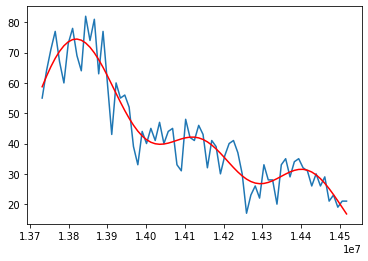

Gaussian fit parameters are given by  [1.38170074e+07 7.41552810e+01 1.25393136e+05 1.41387644e+07
 3.84607371e+01 1.03965308e+05 1.44128779e+07 3.01402491e+01
 9.63476991e+04]


In [476]:
fit4=gauss_curve_fit(bin_centers,bin_heights,10,1223,1294,3,1e5,100000)
print('Gaussian fit parameters are given by ', fit4[1])

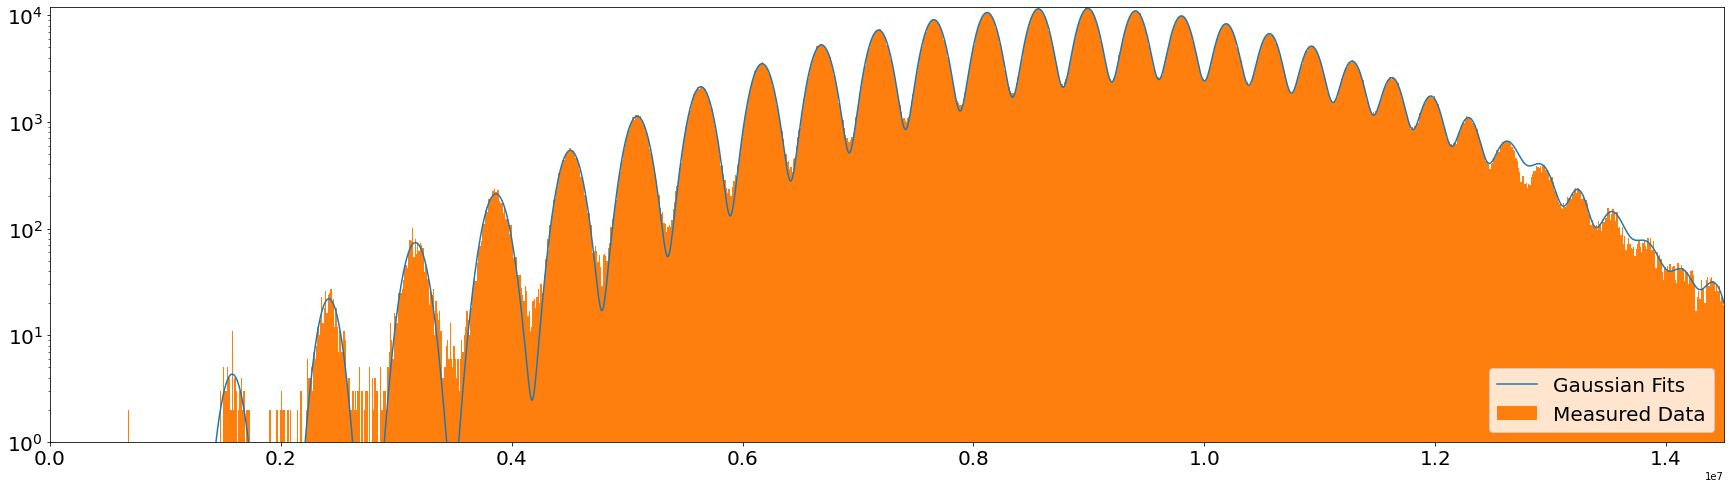

In [487]:
'''Now stitch together all of the fit parameters '''
gauss_params_fin=flatten([fit1[1],fit2[1],fit3[1],fit4[1]])

xvec=np.linspace(0,1.6e7,10000)
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(xvec,gauss_sum(gauss_params_fin,xvec), label='Gaussian Fits')
ax.set_yscale('log')
ax.hist(histvals, bins=2000, label='Measured Data')
ax.set_xlim([0,1.45e7])
ax.set_ylim([1,1.2e4])
ax.tick_params(axis='both', labelsize=20 )
plt.legend(loc='lower right', fontsize=20)

plt.show()

As seen above, the Gaussian fits do a reasonable job of fitting the data with the exception of the zero peaks, which must be included manually. One may notice that some of the peaks, especially near the end, do not fit the distribution as well as one might like. This is due to the fact that the data set only contained 2.5e6 data points. Although this is already a substantial amount, the coherent state used is quite large, and thus more data will more accurately round out the Gaussian fits. When the entirety of this data set is used, the peaks fit the data more accurately and can be used to bin the data as desired. From here, one can rerun the data set with a larger amount of measurements and then perform the same analysis for each channel where data was collected. Once that has been achieved the Gaussian fit parameters can be used to determine binning threshold as per the code in the next section.